In [1]:
import torch
from PIL import Image
import sys
import matplotlib.pyplot as plt
import os
import numpy as np

sys.path.append('../src')
import open_clip

%load_ext autoreload
%autoreload 2

/home/sandeepmukh/open_clip/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model_path0 = "/home/sandeepmukh/open_clip/src/logs/coca_coyo_elr_11/checkpoints/epoch_100.pt"
model_path = "/home/sandeepmukh/open_clip/src/logs/coca_coyo_baseline_4/checkpoints/epoch_100.pt"
model_name = "coca_ViT-B-32"

model, train_prep, preprocess = open_clip.create_model_and_transforms(model_name = model_name)
model_swa, _, _ = open_clip.create_model_and_transforms(model_name = model_name)
ckpt = torch.load(model_path, map_location='cpu')
sd = ckpt['state_dict']
sd = {k[len('module.'):]: v for k, v in sd.items()}
sd = {k: v for k, v in sd.items() if k}
model.load_state_dict(sd)
sd_swa = torch.load(model_path0, map_location='cpu')['distill_state_dict']
sd_swa = {k[len('module.module.'):]: v for k, v in sd_swa.items()}
sd_swa = {k: v for k, v in sd_swa.items() if k}
model_swa.load_state_dict(sd_swa)

tokenizer = open_clip.get_tokenizer(model_name)
model.to(device)
model_swa.to(device)
model.eval()
model_swa.eval();

In [5]:
base_path = "/home/sandeepmukh/open_clip/data/imagenet/validation/"
# randomly sample 10 images from this path
classes = os.listdir(base_path)
img_paths = [[base_path + c + "/" + file for file in os.listdir(base_path + c)] for c in classes if os.path.isdir(base_path + c)]
# flatten the list
img_paths = [item for sublist in img_paths for item in sublist]
np.random.shuffle(img_paths)
imgs = [Image.open(img_path) for img_path in img_paths[:10]]
image = torch.tensor(np.array([preprocess(img) for img in imgs])).cuda(device=device)
with torch.no_grad():
    caption = model.generate(image)
    caption_swa = model_swa.generate(image)

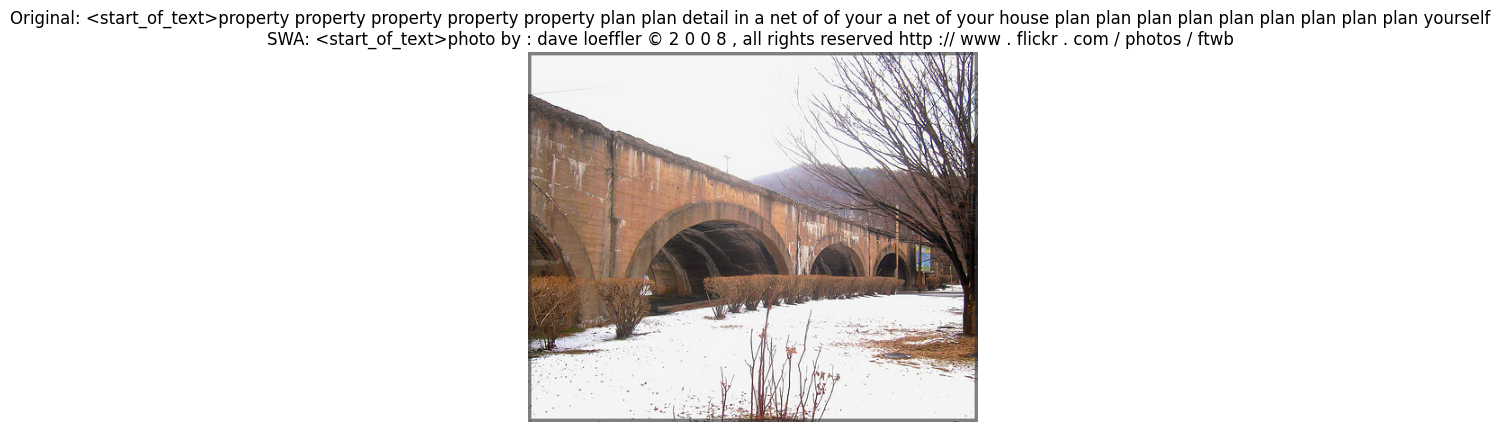

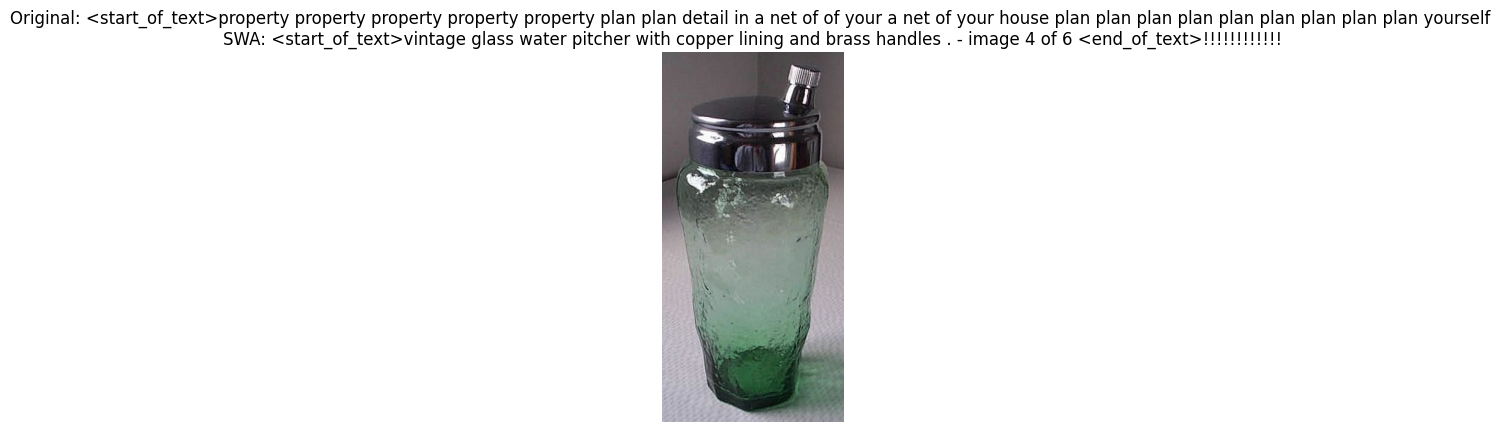

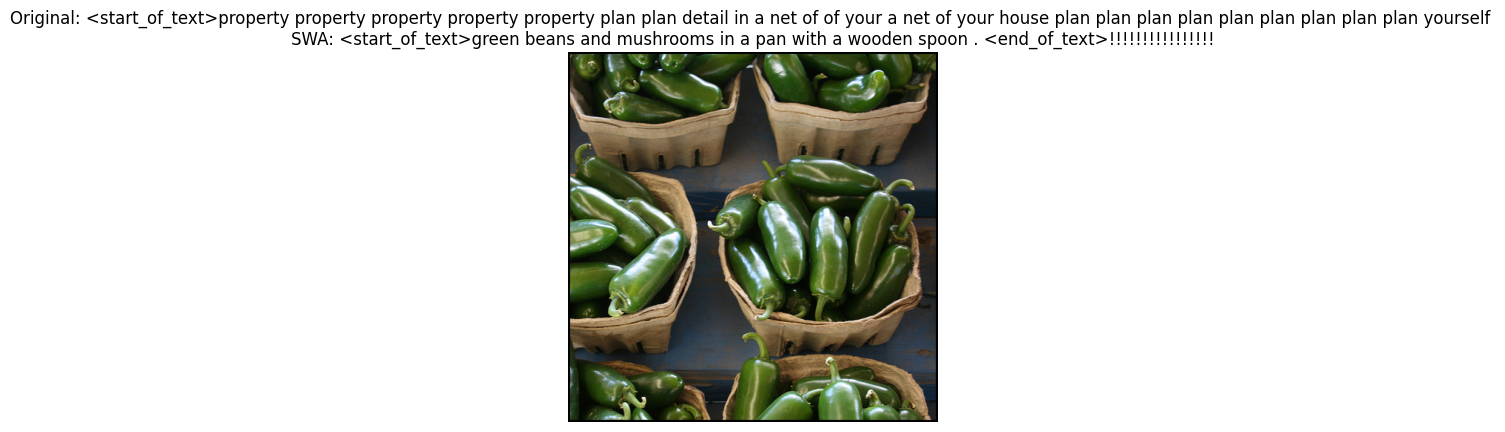

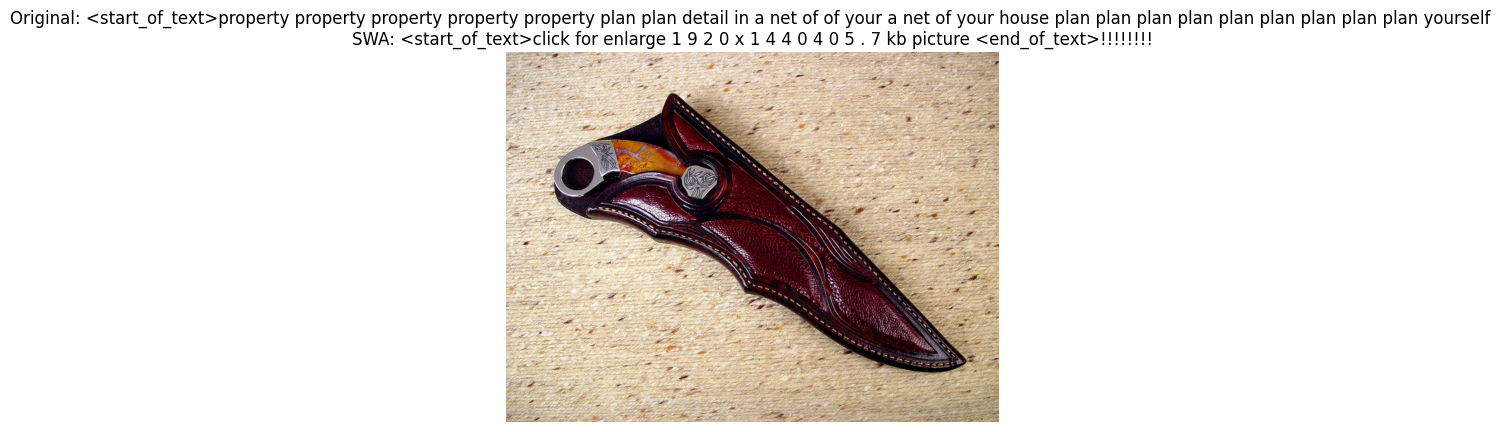

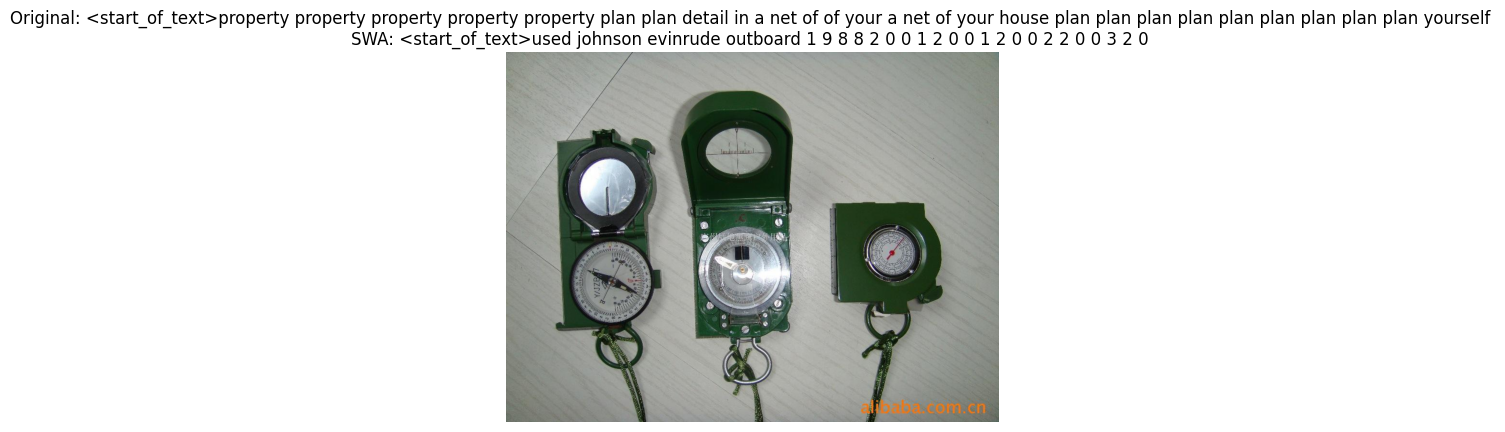

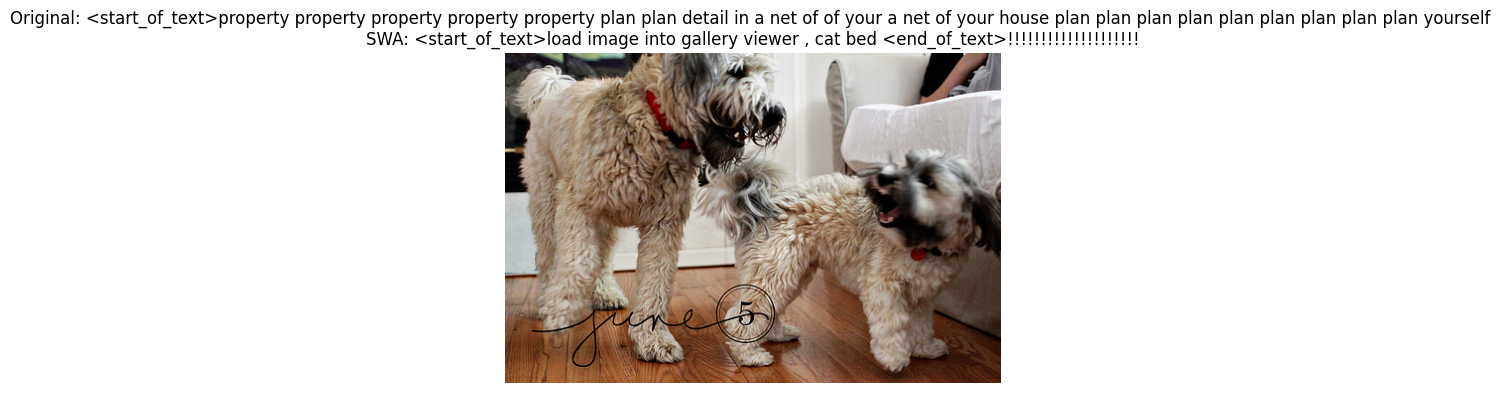

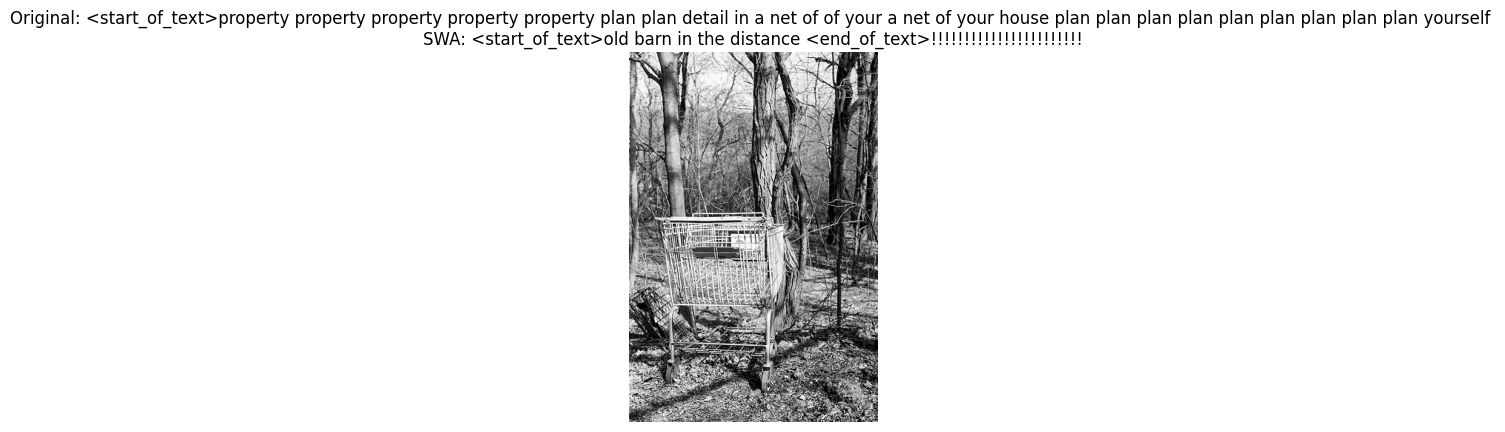

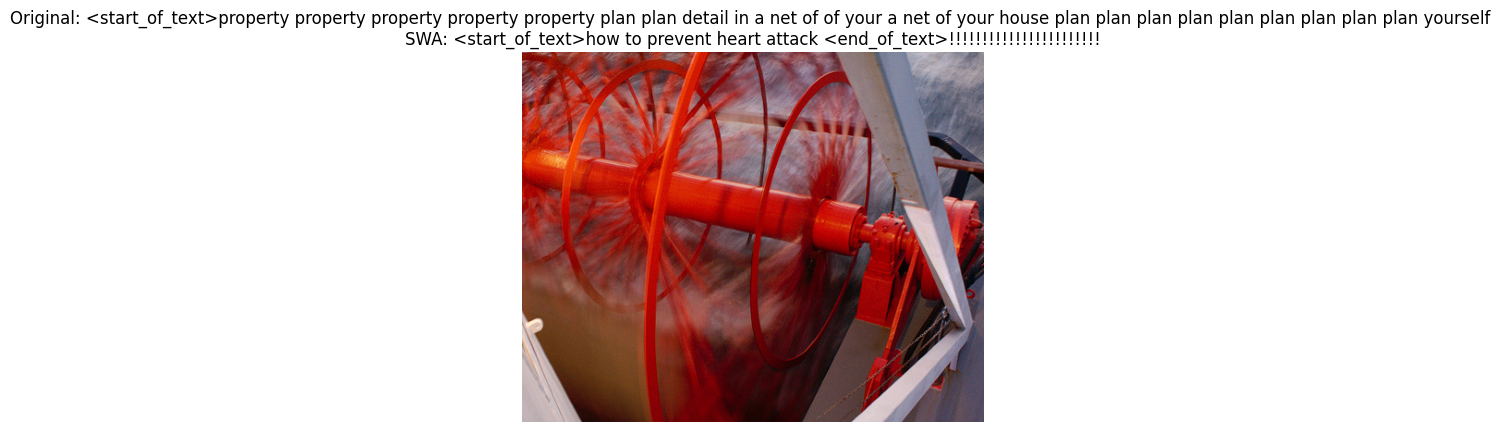

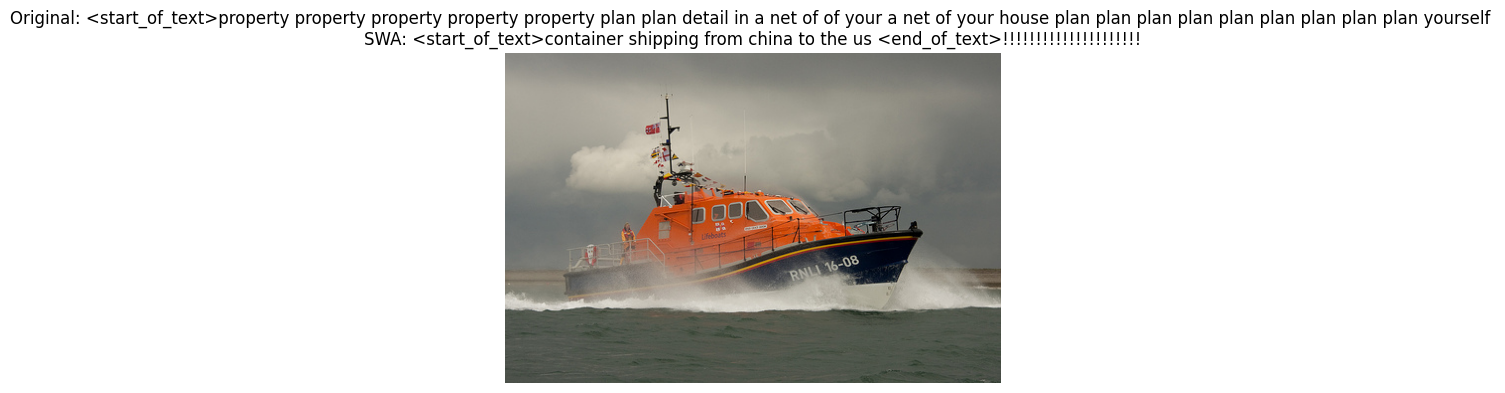

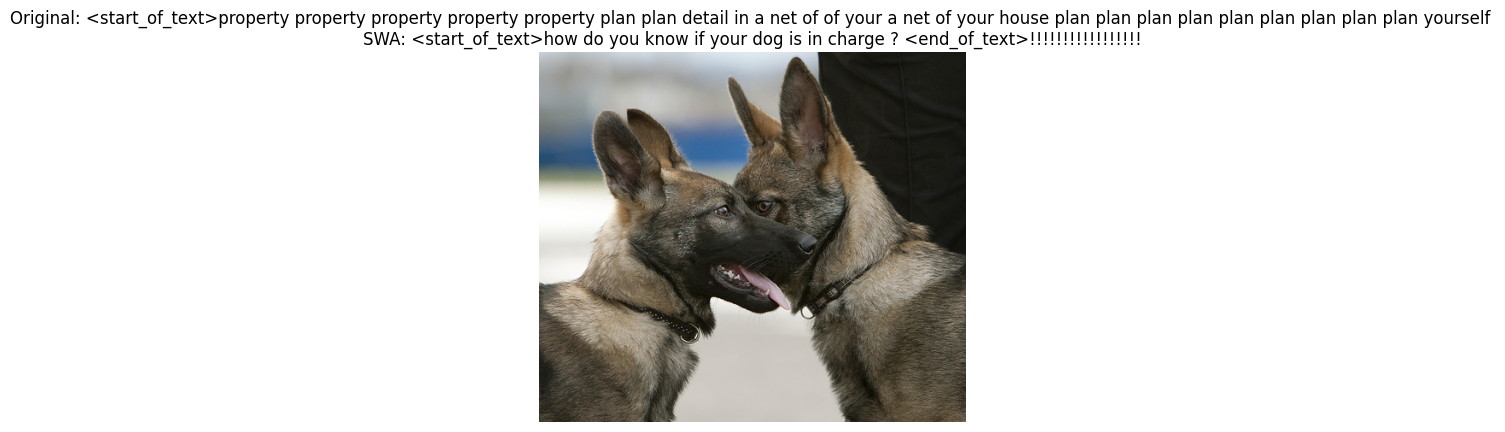

In [6]:
def show_one_pair(img, tokens1, tokens2):
  caption = tokenizer.decode(tokens1.cpu().numpy())
  caption2 = tokenizer.decode(tokens2.cpu().numpy())
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Original: {caption}\nSWA: {caption2}")
  plt.show()
  
for img, caption1, caption2 in zip(imgs, caption, caption_swa):
    show_one_pair(img, caption1, caption2)